In [ ]:
import time, os, datetime, random, re
import numpy as np
import pandas as pd
import torch
SEED =12
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [ ]:
df = pd.read_csv('/content/spellgenerpara.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1000 non-null   int64 
 1   document    1000 non-null   object
 2   summary     1000 non-null   object
dtypes: int64(1), object(2)
memory usage: 23.6+ KB


In [ ]:
df['summary'][:4]

0                         who manufactures cetirizine 
1                      who manufactures bromocriptine 
2           who makes nulytely and where can i buy it 
3    where can i get genetic testing for william s ...
Name: summary, dtype: object

In [ ]:
!pip install folium==0.2.1 -q

     |████████████████████████████████| 69 kB 7.5 MB/s 


In [ ]:
!pip install datasets transformers rouge-score nltk -q

     |████████████████████████████████| 346 kB 32.3 MB/s 
     |████████████████████████████████| 4.2 MB 60.7 MB/s 
     |████████████████████████████████| 212 kB 73.9 MB/s 
     |████████████████████████████████| 86 kB 6.0 MB/s 
     |████████████████████████████████| 140 kB 72.5 MB/s 
     |████████████████████████████████| 86 kB 7.5 MB/s 
     |████████████████████████████████| 1.1 MB 58.1 MB/s 
     |████████████████████████████████| 596 kB 57.3 MB/s 
     |████████████████████████████████| 127 kB 13.7 MB/s 
     |████████████████████████████████| 6.6 MB 147 kB/s 
     |████████████████████████████████| 94 kB 1.3 MB/s 
     |████████████████████████████████| 271 kB 48.3 MB/s 
     |████████████████████████████████| 144 kB 49.7 MB/s 
     |████████████████████████████████| 112 kB 15.5 MB/s 


In [ ]:
!pip install torch==1.11.0 -q

NameError: ignored

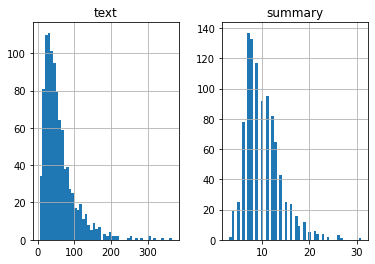

In [ ]:
text_word_count    = []
summary_word_count = []

for i in df['document']:
      text_word_count.append(len(i.split()))

for i in df['summary']:
      summary_word_count.append(len(i.split()))

visualize = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
visualize.hist(bins = 50)
plt.rcParams['figure.figsize'] = (10, 10)
plt.show()

In [ ]:
import torch
import datasets
from datasets import Dataset
from datasets import load_metric

In [ ]:
import transformers
print(transformers.__version__)

4.19.4


In [ ]:
from transformers import AutoTokenizer

model_checkpoint ='t5-small'
    
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

pad_on_right = tokenizer.padding_side == "right"

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5_fast.py:161: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


In [ ]:
tokenizer("Hello, this one sentence!")

{'input_ids': [8774, 6, 48, 80, 7142, 55, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

In [ ]:
max_input_length = 120
max_target_length = 20

In [ ]:
df = df.sample(frac=1).reset_index(drop=True)
train = df[:800]
valid = df[800:850]
test = df[850:]
train.shape, valid.shape,test.shape

((800, 3), (50, 3), (150, 3))

In [ ]:
def preprocess_function(examples):
    inputs = ['summarize:' + doc for doc in examples["document"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True,padding='max_length')

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["summary"], max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
import torch
import datasets
from datasets import Dataset

train = Dataset.from_pandas(train)
valid = Dataset.from_pandas(valid)

In [ ]:
tokenized_train = train.map(preprocess_function, batched=True)
tokenized_valid = valid.map(preprocess_function, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
import transformers
assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

## Fine tuning 

In [ ]:
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer

model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

loading configuration file https://huggingface.co/t5-small/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/fe501e8fd6425b8ec93df37767fcce78ce626e34cc5edc859c662350cf712e41.406701565c0afd9899544c1cb8b93185a76f00b31e5ce7f6e18bbaef02241985
Model config T5Config {
  "_name_or_path": "t5-small",
  "architectures": [
    "T5WithLMHeadModel"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 6,
  "num_heads": 8,
  "num_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_lengt

In [ ]:
batch_size = 16
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
import nltk
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # Rouge expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]
    
    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    # Extract a few results
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    
    # Add mean generated length
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)
    
    return {k: round(v, 4) for k, v in result.items()}

In [ ]:
import gc
gc.collect()

3709

In [ ]:
# determine the device we will be using for training
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("[INFO] training using {}".format(torch.cuda.get_device_name(0)))
#print('There are %d GPU(s) available.' % torch.cuda.device_count())

[INFO] training using Tesla T4


In [ ]:
torch.cuda.empty_cache()

In [ ]:
!pip install wandb
import wandb
!wandb login

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 10.0 MB/s 
     |████████████████████████████████| 145 kB 63.3 MB/s 
     |████████████████████████████████| 181 kB 68.4 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=d64a9d8c9ba8005559973f2fbff352848787b60fcd7906a23f33877dccc78f78
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
wandb.init()
run_name = wandb.run.name

eval/gen_len,█▁▁▃▃▃▂▄▄▅▄▄▆▅▇▄▆▆▆▆▇▅▇▅▇▇▇▇▇▇
eval/loss,█▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/rouge1,▁▅▄▃▃▅▆▇▆▇▆▆▇▇▇▇█▇▇███▇▇██▇███
eval/rouge2,▁▇▆▄▄▅▇▇▇▇▆▇▇▇▇██▇▇▇▇▇▇▆▇▇▆▇▇▇
eval/rougeL,▁▆▅▄▄▅▆█▇▇▇▇▇█▇███▇▇▇█▇▇██▇▇▇▇
eval/rougeLsum,▁▆▅▄▄▆▆█▇▇▇▇▇█▇███▇▇▇█▇▇▇█▇▇▇▇
eval/runtime,▆▆▂▃▂▃▁▅▅█▆█▆▅▇▇▅▅▂█▄▆▄▅▅▆▄▆▆█
eval/samples_per_second,▂▃▆▆▇▆█▃▄▁▃▁▂▃▂▂▄▄▇▁▅▃▅▄▄▃▅▃▂▁
eval/steps_per_second,▂▃▆▆▇▆█▃▄▁▃▁▂▃▂▂▄▄▇▁▅▃▅▄▄▃▅▃▂▁
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


In [ ]:
%env WANDB_DISABLED=False

env: WANDB_DISABLED=False


In [ ]:
model_name = model_checkpoint.split("/")[-1]
args = Seq2SeqTrainingArguments(
    f"{model_name}-finetuned-T5",
    
    evaluation_strategy = "epoch",
    learning_rate=7e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=30,
    logging_dir='./logs',            # directory for storing logs*
    logging_steps=5,
    #evaluation_strategy="steps"
    run_name='run_name', # Wandb run name 
    #num_beams=5,
    eval_steps=None, # How often to run evaluation on the val_set
    logging_first_step=False, # Whether to log also the very first training step to wandb
    predict_with_generate=True,
    fp16=True
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_valid,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

Using amp half precision backend


In [ ]:
metric = load_metric("rouge")

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: summary, document, Unnamed: 0. If summary, document, Unnamed: 0 are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 800
  Num Epochs = 30
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1500
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,2.292700,1.939403,35.750700,17.754800,33.437900,33.428200,14.280000
2,1.927100,1.787347,46.601100,27.391400,44.758700,44.656100,12.360000
3,1.587800,1.723169,48.112400,28.543700,45.971700,45.749100,12.020000
4,1.562700,1.684580,47.952000,27.544600,45.829700,45.702900,12.120000
5,1.808700,1.659231,47.299100,25.334300,44.666100,44.370800,12.060000
6,1.360600,1.641438,46.480600,25.375400,43.498300,43.303000,12.520000
7,1.637600,1.623105,46.128300,25.061500,43.665900,43.511300,12.580000
8,1.446000,1.620575,47.735100,26.001000,45.026400,44.760000,12.380000
9,1.319400,1.614880,47.644600,26.310100,44.947500,44.804000,12.240000
10,1.533700,1.610091,48.419000,26.611600,45.073800,44.805000,12.360000


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: summary, document, Unnamed: 0. If summary, document, Unnamed: 0 are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 50
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: summary, document, Unnamed: 0. If summary, document, Unnamed: 0 are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 50
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: summary, document, Unnamed: 0. If summary, document, Unnamed: 0 are not expected by `T5ForConditionalGeneration.for

TrainOutput(global_step=1500, training_loss=1.3559353199005126, metrics={'train_runtime': 206.0221, 'train_samples_per_second': 116.492, 'train_steps_per_second': 7.281, 'total_flos': 761297633280000.0, 'train_loss': 1.3559353199005126, 'epoch': 30.0})

In [ ]:
eval_dataset = Dataset.from_pandas(test)

In [ ]:
eval_dataset = eval_dataset.map(
                preprocess_function,
                batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
predict_results = trainer.predict(
            eval_dataset,max_length=20, num_beams=5)

The following columns in the test set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: summary, document, Unnamed: 0. If summary, document, Unnamed: 0 are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 150
  Batch size = 16


In [ ]:
metrics = predict_results.metrics

In [ ]:
if args.predict_with_generate:
    predictions = tokenizer.batch_decode(predict_results.predictions, skip_special_tokens=True, clean_up_tokenization_spaces=True)
    predictions = [pred.strip() for pred in predictions]

In [ ]:
metrics

{'test_gen_len': 13.4933,
 'test_loss': 1.6268328428268433,
 'test_rouge1': 44.5012,
 'test_rouge2': 29.2883,
 'test_rougeL': 43.2582,
 'test_rougeLsum': 43.0888,
 'test_runtime': 4.542,
 'test_samples_per_second': 33.025,
 'test_steps_per_second': 2.202}

In [ ]:
test['summary'][:10]

850    where can i find information on ankle implant ...
851    what is the prognosis and course of recovery a...
852               how do i dispose of hydrogen peroxide 
853    what are natural remedies for difficulty walking 
854    what are the ingredients of klor con m and is ...
855    where can i find information on folgard os in ...
856    where can i find information on posterior foss...
857    what are the complications from sacralcoccygea...
858    what are treatments for paralysis after stroke...
859            can a diuretic be taken with allopurinol 
Name: summary, dtype: object

In [ ]:
predictions[:10]

['where can i find information on steel plate in my ankle from a severely broken leg',
 'what are the patterns of recovery after stroke',
 'how do i dispose of hydrogen perox e',
 'where can i find information on thiamin mg strong vitamin b compound s',
 'what are the ingredients of klor con tabs meq',
 'where can i find information on folgard os',
 'what are the treatments for posterior fossa',
 'where can i find information on sacralcoccygeal teratoma tumor',
 'what are the treatments for paralysis',
 'what are the risks of taking allopurinol and diuretics']

In [ ]:
test['document'][851]

' recovery after stroke what is the pattern of recovery after stroke '

In [ ]:
test['summary'][851]

'what is the prognosis and course of recovery after stroke '

In [ ]:
predictions[1]

'what are the patterns of recovery after stroke'

In [ ]:
wandb.finish()

eval/gen_len,▁▄▄▁▄▇▆▃█▃▇▅▆▆▅▂▇▄▃▄▂▇▃▅▅▅▆▅▅▅
eval/loss,▁▂▂▂▂▃▃▃▃▅▅▅▆▆▆▆▇▇██████▇▇▇▇▇▇
eval/rouge1,▇▁█▂▇▅▆▆▆▄▆▆▆▃▄▅▂▂▆▅▁▄▃▅▅▄▂▄▄▅
eval/rouge2,▇▃█▃▆▅▆▅▆▃▅▅▄▄▄▄▃▃▅▄▁▄▂▄▃▃▂▃▃▄
eval/rougeL,▇▁█▃▇▆▆▇▇▄▆▆▆▄▅▅▂▃▆▅▂▄▃▅▅▅▃▄▄▅
eval/rougeLsum,▇▁█▃▇▆▆▆▇▄▆▆▆▄▅▅▂▃▆▅▂▄▃▅▅▅▃▄▄▅
eval/runtime,██▁▁▁▁▁▂▁▁▁▁▁▅▁▁▁▁▁▁▁▁▁▂▁▁▁▄▁▁
eval/samples_per_second,▁▁▇██▇█▇█▇█▇█▃█▇█▇█▇█▇█▇█▇█▃█▇
eval/steps_per_second,▁▁▇██▇█▇█▇█▇█▃█▇█▇█▇█▇█▇█▇█▃█▇
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


In [ ]:
model_dir = '/content/drive/MyDrive/Colab Notebooks/T5'
trainer.save_model(model_dir + 'T5')

Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/T5T5
Configuration saved in /content/drive/MyDrive/Colab Notebooks/T5T5/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/T5T5/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/Colab Notebooks/T5T5/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/Colab Notebooks/T5T5/special_tokens_map.json
